In [2]:
from utils.basic_wasserstein import compute_sliced_wass_barycenter, compute_wasserstein_barycenter
from utils.image_treatment import preprocess_image, image_to_distribution
import matplotlib.pyplot as plt

In [3]:
image1 = preprocess_image('data/elephant.jpg', end = 'L')
image2 = preprocess_image('data/cercle.png', end = 'L')
x1 = image_to_distribution(image1)
x2 = image_to_distribution(image2)

In [6]:
def projection(X0, Y):
    """
    X0 : image a projeter 
    Y : ce sur quoi on veut projeter 
    """
    Y_distrib = [Y]
    proj = compute_sliced_wass_barycenter(Y_distrib, rho = None, lr = 1e3, k = 200, nb_iter_max = 50, xbinit = X0)
    return(proj)

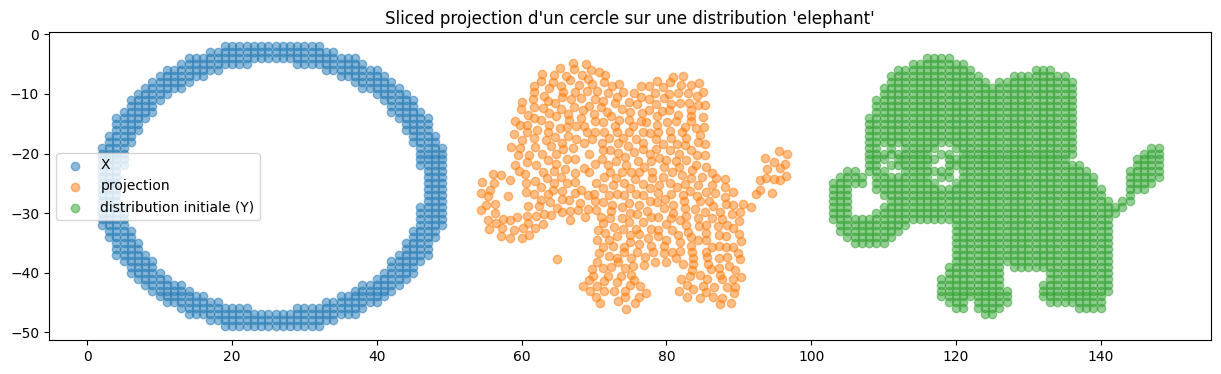

In [7]:
xprojection = projection(x2, x1)

plt.figure(6, (15, 4))
plt.scatter(x2[:, 0], x2[:, 1], alpha=0.5, label = 'X')
plt.scatter(xprojection[:, 0]+50, xprojection[:, 1], alpha=0.5, label = 'projection')
plt.scatter(x1[:, 0]+100, x1[:, 1], alpha=0.5, label = "distribution initiale (Y)")
plt.title("Sliced projection d'un cercle sur une distribution \'elephant\'")
plt.legend()

# Plot GIF

In [8]:
import torch 
import numpy as np 
import ot 

import matplotlib.pyplot as plt
import imageio

def compute_sliced_wass_barycenter(distributions, rho=None, lr=1e3, k=200, nb_iter_max=50, xbinit=None):
    device = "cuda" if torch.cuda.is_available() else "cpu"

    x_torch = [torch.tensor(x).to(device=device) for x in distributions]

    if rho is None: 
        n = len(distributions)
        rho = n * [1 / n]
    
    if xbinit is None:
        xbinit = np.random.normal(0., 1., distributions[0].shape)
    xbary_torch = torch.tensor(xbinit).to(device=device).requires_grad_(True)

    x_all = np.zeros((nb_iter_max, xbary_torch.shape[0], xbary_torch.shape[1]))
    loss_iter = []

    # generator for random projections
    gen = torch.Generator(device=device)
    gen.manual_seed(42)

    for i in range(nb_iter_max):
        loss = 0
        for j, x in enumerate(x_torch):
            loss += rho[j] * ot.sliced_wasserstein_distance(xbary_torch, x, n_projections=50, seed=gen)
        loss_iter.append(loss.clone().detach().cpu().numpy())
        loss.backward()

        # Perform gradient descent
        with torch.no_grad():
            grad = xbary_torch.grad
            xbary_torch -= grad * lr  # / (1 + i / 5e1)  # step
            xbary_torch.grad.zero_()
            x_all[i, :, :] = xbary_torch.clone().detach().cpu().numpy()
        lr *= 0.981
    xb = xbary_torch.clone().detach().cpu().numpy()

    return (xb, x_all)


def create_gif(x_all, y_points, filename="projection.gif"):
    """
    Crée un GIF montrant l'évolution de X vers Y.
    
    Parameters:
        x_all : ndarray
            Tableau contenant l'évolution de X à chaque itération.
        y_points : ndarray
            Points de Y pour référence.
        filename : str
            Nom du fichier GIF généré.
    """
    images = []
    for i, x in enumerate(x_all):
        plt.figure(figsize=(6, 6))
        
        # Modifier la couleur de fond
        ax = plt.gca()
        ax.set_facecolor('lightgray')
        
        # Tracer les points
        plt.scatter(x[:, 0], x[:, 1], c='blue', label='Projected X', alpha=0.6)
        plt.scatter(y_points[:, 0], y_points[:, 1], c='red', label='Target Y', alpha=0.2)
        
        # Ajouter une légende
        plt.legend(loc='upper right')

        # # Ajouter le numéro d'itération en bas à gauche
        # plt.text(2, -48, f"Iteration {i + 1}", fontsize=12, color='black',
        #          ha='left', va='bottom', bbox=dict(facecolor='white', alpha=0.7))
        
        
        # Ajuster les limites
        plt.xlim(0, 50)
        plt.ylim(-50, 0)
        
        # Supprimer les axes et la grille
        plt.axis('off')
        
        # Sauvegarder chaque frame
        plt.savefig("frame.png", bbox_inches='tight', pad_inches=0)
        images.append(imageio.imread("frame.png"))
        plt.close()
    
    # Combine images into a GIF
    imageio.mimsave(filename, images, fps=20, loop=5)


In [9]:
def resize_array(arr):
    range_col1 = (0, 50)  # Première colonne : [0, 50]
    range_col2 = (-50, 0) # Deuxième colonne : [-50, 0]

    # Redimensionner la première colonne
    col1_min, col1_max = arr[:, 0].min(), arr[:, 0].max()
    arr[:, 0] = range_col1[0] + (arr[:, 0] - col1_min) * (range_col1[1] - range_col1[0]) / (col1_max - col1_min)

    # Redimensionner la deuxième colonne
    col2_min, col2_max = arr[:, 1].min(), arr[:, 1].max()
    arr[:, 1] = range_col2[0] + (arr[:, 1] - col2_min) * (range_col2[1] - range_col2[0]) / (col2_max - col2_min)

    return arr

In [10]:
image1 = preprocess_image('data/elephant.jpg', end = 'L')
image2 = preprocess_image('data/cercle.png', end = 'L')
x1 = image_to_distribution(image1, reduc=5)
x2 = image_to_distribution(image2, reduc=3)
x2 = resize_array(x2)
x2 = x2[np.random.choice(len(x2), x1.shape[0], replace=False)]

In [11]:
# Calcul de la projection
proj, x_all = compute_sliced_wass_barycenter([x1], xbinit=x2, nb_iter_max=100, lr=1e3)

In [12]:
# Création du GIF
create_gif(x_all, x1, filename="outputs/projection.gif")

/var/folders/nk/rqbxbzbs6cx3djvmyg89hzhh0000gn/T/ipykernel_4075/1641621429.py:88: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread("frame.png"))


# Final Plots

In [18]:
def simple_projection(X0, Y, k=200):
    """
    X0 : image a projeter 
    Y : ce sur quoi on veut projeter 
    """
    Y_distrib = [Y]
    proj = compute_wasserstein_barycenter(Y_distrib, weights= None, k = k)
    return(proj)

In [19]:
xprojection = projection(x2, x1)
xprojection_simple = simple_projection(x2, x1, k=len(x2))

TypeError: tuple indices must be integers or slices, not tuple

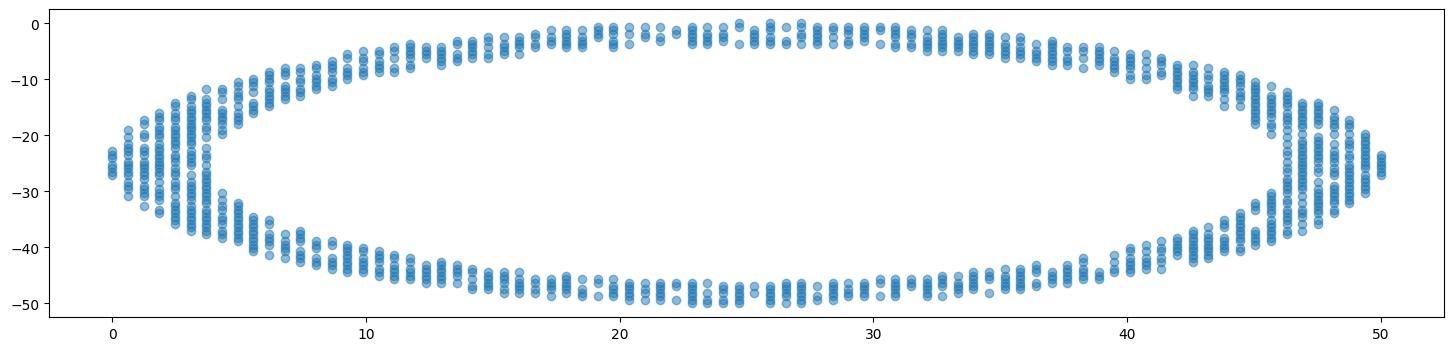

In [20]:
plt.figure(6, (18, 4))
plt.scatter(x2[:, 0], x2[:, 1], alpha=0.5, label = 'X')
plt.scatter(xprojection[:, 0]+50, xprojection[:, 1], alpha=0.5, label = '$\\tilde{Proj}_{[Y]}(X)$')
plt.scatter(xprojection_simple[:, 0]+100, xprojection_simple[:, 1], alpha=0.5, label = '$Proj_{[Y]}(X)$')
plt.scatter(x1[:, 0]+150, x1[:, 1], alpha=0.5, label = "Y")
#plt.title("Sliced projection d'un cercle sur une distribution \'elephant\'")
plt.legend()
plt.axis("off")

TypeError: tuple indices must be integers or slices, not tuple

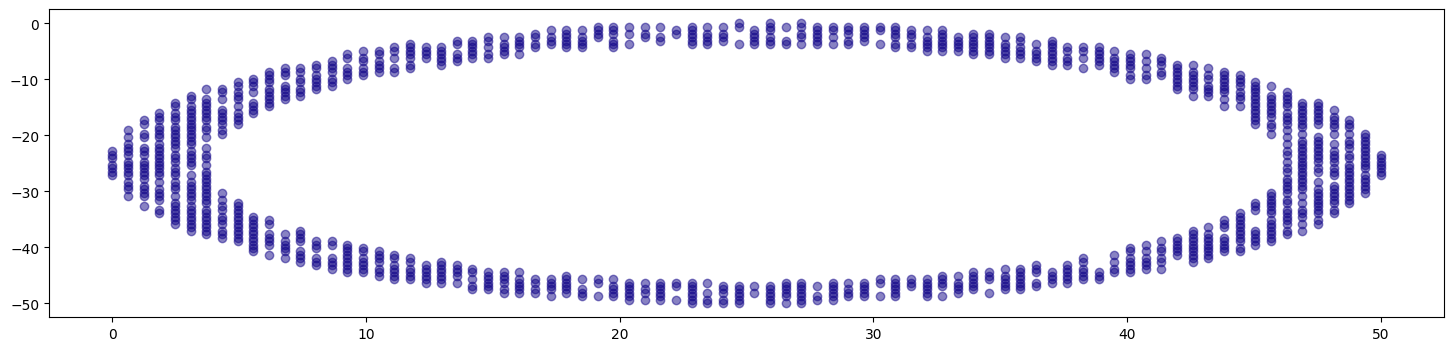

In [21]:
cmap = plt.cm.plasma
colors = [cmap(i) for i in [0.01, 0.3, 0.55]] + ["#ff7f0e"]
plt.figure(6, (18, 4))

plt.scatter(x2[:, 0], x2[:, 1], alpha=0.5, label='X', color=colors[0])
plt.scatter(xprojection[:, 0] + 50, xprojection[:, 1], alpha=0.5, label='$\\tilde{Proj}_{[Y]}(X)$', color=colors[1])
plt.scatter(xprojection_simple[:, 0] + 100, xprojection_simple[:, 1], alpha=0.5, label='$Proj_{[Y]}(X)$', color=colors[2])
plt.scatter(x1[:, 0] + 150, x1[:, 1], alpha=0.5, label="Y", color=colors[3])

# Titles
plt.text(np.mean(x2[:, 0]), np.mean(x2[:, 1]) - 32, 'X', ha='center', fontsize=24)

plt.text(np.mean(xprojection[:, 0] + 50), np.mean(xprojection[:, 1]) - 32, "$\\tilde{Proj}_{[Y]}(X)$", ha='center', fontsize=24)

plt.text(np.mean(xprojection_simple[:, 0] + 100), np.mean(xprojection_simple[:, 1]) - 32, '$Proj_{[Y]}(X)$', ha='center', fontsize=24)

plt.text(np.mean(x1[:, 0] + 150), np.mean(x1[:, 1]) -32, 'Y', ha='center', fontsize=24)


plt.axis("off")
plt.show()